<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_CNN_%EC%A0%80%EC%9E%A5_%EB%A1%9C%EB%93%9C_Ensemble_%5B%EC%A1%B0%EA%B5%90%EC%9A%A9%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np
import random
import time
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False

In [ ]:
!gdown --id 1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
!mkdir 'semicon'
!unzip -q semiconductor_dataset.zip -d semicon
!rm semiconductor_dataset.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
To: /content/semiconductor_dataset.zip
100% 10.3M/10.3M [00:00<00:00, 187MB/s]


In [ ]:
import csv
import os
import pandas as pd
"""
Args:
  directory_string: 이미지가 저장되어 있는 폴더 Path
  output_csv_name: csv 파일 이름
Returns:
  csv file
"""
def build_csv(directory_string, output_csv_name):

    directory = directory_string
    class_list = os.listdir(directory)
    class_list.sort()


    with open(output_csv_name, 'w', newline='') as csvfile:

        ### 실습 : CSV 파일 Object 생성
        writer = csv.writer(csvfile, delimiter=',')
        ############################################
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index']) # CSV의 column 이름을 지정

        ###### 각 folder에 들어가서 각 이미지의 이름을 가져옴
        for class_name in class_list:
          class_path = os.path.join(directory, class_name)
          file_list = os.listdir(class_path) # 해당 파일 내부의 이미지를 확보
          for file_name in file_list:
              file_path = os.path.join(directory, class_name, file_name) #concatenate class folder dir, class name and file name
              writer.writerow([file_name, file_path, class_name, class_name.split("_")[1]]) #write the file path and class name to the csv file
        #############################

    return

train_folder = os.path.join(os.getcwd(), 'semicon')
build_csv(train_folder, 'train.csv')
train_df = pd.read_csv('train.csv')


# Custom데이터를 활용하기 위한 Dataset을 선언
- pytorch의 `dataloader`를 이용하기 위해서는 `torch.utils.data.Dataset` 클래스를 상속한 클래스의 선언이 필요하다.
- 클래스 내에 `__init__`, `__getitem__`, `__len__`의 3개의 메소드를 선언하여 오버라이드한다.

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class semiconductorDataset(Dataset): # inheritin from Dataset class

    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir # root directory of images, leave "" if using the image path column in the __getitem__ method
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df) # return length (numer of rows) of the dataframe

    ############ 실습 : annotation_df에 있는 이미지를 읽어 들어서, 변경한후
    ############        읽어 들인 값을 return 하는 함수를 작성한다.
    def __getitem__(self, idx):

        ##### Image 읽기
        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1]) #use image path column (index = 1) in csv file
        image = cv2.imread(image_path) # read image by cv2
        #### 이미지를 Channel순서를 변경
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB for matplotlib
        #### 이미지 Transform
        if self.transform:
            image = self.transform(image)

        #### 이미지에 대한 추가 정보 확인
        class_name = self.annotation_df.iloc[idx, 2] # use class name column (index = 2) in csv file
        class_index = self.annotation_df.iloc[idx, 3] # use class index column (index = 3) in csv file

        return image, class_name, class_index

In [ ]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import pandas as pd


transform = transforms.Compose([
    transforms.ToTensor(), # PIL Image를 Tensor로 변경
    transforms.Resize((256,256), antialias=True), # 크기 변경
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Normalize
    transforms.Grayscale(), # Gray Scale로 변경
    transforms.RandomAdjustSharpness(sharpness_factor=2), # randomly adjusts the sharpness
    transforms.RandomAutocontrast() # 임의로 Contrast변경
])

##### 실습 : train_dataset 선언
train_dataset = semiconductorDataset(csv_file='train.csv', root_dir="", transform=transform)

In [ ]:
## 실습 : 전체 데이터를 한번에 가져오고, 이 결과를 기반으로 Report출력
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

labels, predicted,images, names = None, None, None, None
with torch.no_grad():
  for images, names,  labels in train_dataloader:
    continue

### 입력 이미지를 numpy 로 변경
print(images.shape)


torch.Size([198, 1, 256, 256])


In [ ]:
images = images.squeeze()
print(images.shape)

images = images.view(images.shape[0], -1)
images.shape

torch.Size([198, 256, 256])


torch.Size([198, 65536])

In [ ]:
# Image plotting function
def img_plt(X_train, Y_train, n):
  X_train_2d = X_train.reshape(X_train.shape[0], 256, 256)
  fig, axes = plt.subplots(n, 10, figsize=(10,10))
  for j in range(n):
    for i in range(10):
        ax = axes[j, i]
        try:
          ax.imshow(X_train_2d[Y_train==j][i], cmap='gray_r')
          ax.axis('off')
          if i == 0:
            ax.set_title('Cluster: {}'.format(j))
        except:
          ax.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
X_train = images.numpy()
Y_train = labels.numpy().shape
## Clustering
from sklearn import cluster
n = 3 # number of clusters
model = cluster.KMeans(n_clusters=n, random_state=1) # 'Kmeans' from 'sklearn.cluster', 'n_cluster' default=2
Y_train = model.fit_predict(X_train) # their clustering result using 'X_train_s' will be assigned to 'Y_train'


In [ ]:
labels

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
model.labels_

array([2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 1,
       2, 2, 2, 1, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
       2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2,
       0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2],
      dtype=int32)

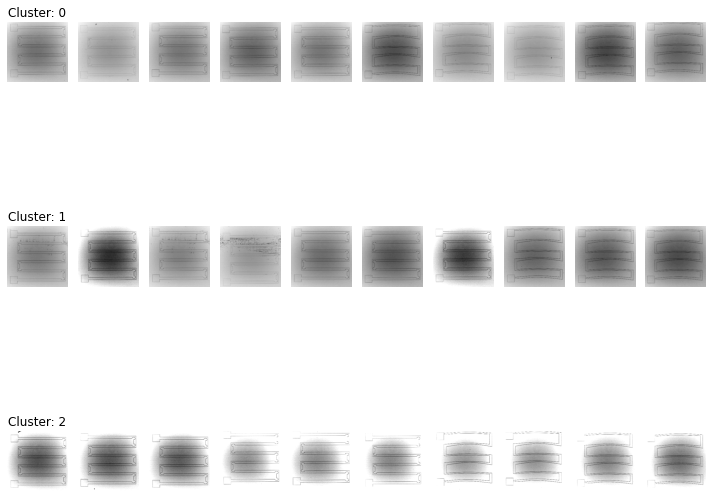

In [ ]:
img_plt(X_train, Y_train, n) # plot

# Batch 단위 학습을 위한 DataLoader 선언
 - Dataset내부의 샘플들을 batch 크기로 추출
 - Batch Size는 1step에 들어간 데이터의 개수
 - Epoch 마다 데이터를 섞어(Shuffle) Overfitting을 방지
 - 병렬처리를 지원하여 데이터 검색 속도를 향상


In [ ]:
#### 실습 : torch.utils.DataLoader를 이용하여 데이터를 load. Batch 크기를 10으로 한다.
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=True, num_workers=2)

for i, data in enumerate(train_dataloader):
  images, class_name, labels = data
  print(images.shape, labels.shape)

  # 5번만 데이터를 load하고 멈춘다
  if i > 3:
    break

torch.Size([10, 1, 256, 256]) torch.Size([10])
torch.Size([10, 1, 256, 256]) torch.Size([10])
torch.Size([10, 1, 256, 256]) torch.Size([10])
torch.Size([10, 1, 256, 256]) torch.Size([10])
torch.Size([10, 1, 256, 256]) torch.Size([10])


# VGG6를 이용하여 학습을 수행한다
![](https://drive.google.com/uc?export=view&id=1vLrvhxczx1ZCOH05cxzzESylaOaF1Uj2)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class VGG_BatchNormTorch(nn.Module):
  def __init__(self, in_channels, out_features):
    super(VGG_BatchNormTorch, self).__init__()

    ###### 실습 : Gray이미지 이므로 in_channel =1 로 선언한다
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
    self.norm1 = torch.nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2 = torch.nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.norm3 = torch.nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.norm4 = torch.nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm5 = torch.nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm6 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

    ###### 실습 : 11개의 Label이 있으므로 out_features=11로 선언한다
    self.fc = nn.Linear(in_features=128, out_features=out_features)

  def forward(self, x):
    #### 실습 : Batch Norm을 Convolution 이후에 선언
    x = self.norm1(self.conv1(x))
    x = F.relu(x)
    x = self.norm2(self.conv2(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm3(self.conv3(x))
    x = F.relu(x)
    x = self.norm4(self.conv4(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm5(self.conv5(x))
    x = F.relu(x)
    x = self.norm6(self.conv6(x))
    x = F.relu(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):

  model.train() #
  for epoch in range(n_epoch):
    running_loss = 0
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for i, (images, _, labels) in enumerate(data_loader):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))

    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
def eval(model, data_loader):

  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for images, _,  labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

  print('Test Accuracy: {}%'.format(accuracy))

In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train(vgg_batchnorm_model, train_dataloader, criterion, optimizer, n_epoch=50)

Epoch 1, loss = 2.407
Epoch 2, loss = 2.340
Epoch 3, loss = 2.203
Epoch 4, loss = 2.155
Epoch 5, loss = 2.025
Epoch 6, loss = 1.889
Epoch 7, loss = 1.780
Epoch 8, loss = 1.721
Epoch 9, loss = 1.630
Epoch 10, loss = 1.558
Epoch 11, loss = 1.465
Epoch 12, loss = 1.395
Epoch 13, loss = 1.380
Epoch 14, loss = 1.305
Epoch 15, loss = 1.226
Epoch 16, loss = 1.193
Epoch 17, loss = 1.139
Epoch 18, loss = 1.103
Epoch 19, loss = 1.083
Epoch 20, loss = 1.027
Epoch 21, loss = 0.958
Epoch 22, loss = 0.964
Epoch 23, loss = 0.904
Epoch 24, loss = 0.901
Epoch 25, loss = 0.813
Epoch 26, loss = 0.789
Epoch 27, loss = 0.783
Epoch 28, loss = 0.758
Epoch 29, loss = 0.706
Epoch 30, loss = 0.705
Epoch 31, loss = 0.647
Epoch 32, loss = 0.601
Epoch 33, loss = 0.575
Epoch 34, loss = 0.545
Epoch 35, loss = 0.521
Epoch 36, loss = 0.495
Epoch 37, loss = 0.446
Epoch 38, loss = 0.474
Epoch 39, loss = 0.442
Epoch 40, loss = 0.467
Epoch 41, loss = 0.410
Epoch 42, loss = 0.449
Epoch 43, loss = 0.456
Epoch 44, loss = 0.3

# 정확도를 평가해 봅시다
* 데이터가 너무 적어서 평가 데이터에 대한 정확도를 봅니다

In [ ]:
eval(vgg_batchnorm_model, train_dataloader)

Test Accuracy: 96.46464646464646%


# 선언한 모델의 구조를 확인한다

In [ ]:
print("Our model: \n\n", vgg_batchnorm_model, '\n')


Our model: 

 VGG_BatchNormTorch(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
vgg_batchnorm_model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'norm1.weight', 'norm1.bias', 'norm1.running_mean', 'norm1.running_var', 'norm1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'norm2.weight', 'norm2.bias', 'norm2.running_mean', 'norm2.running_var', 'norm2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'norm3.weight', 'norm3.bias', 'norm3.running_mean', 'norm3.running_var', 'norm3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'norm4.weight', 'norm4.bias', 'norm4.running_mean', 'norm4.running_var', 'norm4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'norm5.weight', 'norm5.bias', 'norm5.running_mean', 'norm5.running_var', 'norm5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'norm6.weight', 'norm6.bias', 'norm6.running_mean', 'norm6.running_var', 'norm6.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [ ]:
vgg_batchnorm_model.state_dict()

OrderedDict([('conv1.weight', tensor([[[[ 0.0066, -0.2340,  0.0567],
                        [-0.2294,  0.0351, -0.1452],
                        [ 0.1139,  0.2662, -0.0834]]],
              
              
                      [[[ 0.0348, -0.0225,  0.1616],
                        [ 0.1143, -0.0587,  0.1877],
                        [-0.0323,  0.0571, -0.4033]]],
              
              
                      [[[-0.2240,  0.2695, -0.2578],
                        [ 0.0040,  0.2541, -0.0687],
                        [-0.0097,  0.1531, -0.2528]]],
              
              
                      [[[ 0.1788, -0.1350, -0.0011],
                        [ 0.0963,  0.3227,  0.0280],
                        [-0.2664,  0.1560, -0.2582]]],
              
              
                      [[[ 0.1572, -0.0439,  0.2119],
                        [-0.0599, -0.3971,  0.1932],
                        [-0.2911,  0.1726,  0.1117]]],
              
              
                      [[[-0.3

# 모델을 저장하고 불러 들인다.

## state_dict를 저장

In [ ]:
### 위에 학습한 모델을 저장합니다. 저장파일 이름은 checkpoint.pth 입니다.
torch.save(vgg_batchnorm_model.state_dict(), 'checkpoint.pth')

## state_dict를 새로 선언한 모델에 load

In [ ]:
#### 저장한 state_dict를 로드하고, 선언된 모델에 해당 내용을 load합니다.
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())
vgg_loaded = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
vgg_loaded.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'norm1.weight', 'norm1.bias', 'norm1.running_mean', 'norm1.running_var', 'norm1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'norm2.weight', 'norm2.bias', 'norm2.running_mean', 'norm2.running_var', 'norm2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'norm3.weight', 'norm3.bias', 'norm3.running_mean', 'norm3.running_var', 'norm3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'norm4.weight', 'norm4.bias', 'norm4.running_mean', 'norm4.running_var', 'norm4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'norm5.weight', 'norm5.bias', 'norm5.running_mean', 'norm5.running_var', 'norm5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'norm6.weight', 'norm6.bias', 'norm6.running_mean', 'norm6.running_var', 'norm6.num_batches_tracked', 'fc.weight', 'fc.bias'])


<All keys matched successfully>

In [ ]:
eval(vgg_loaded, train_dataloader)

Test Accuracy: 96.96969696969697%


# 주기적으로 checkpoint를 저장

In [ ]:
def train_ckpt(model, data_loader, criterion, optimizer, n_epoch):

  ########## 2 Epoch 마다 Check point 를 저장하는 학습부를 작성해 봅니다.
  model.train() #
  for epoch in range(n_epoch):
    running_loss = 0
    for i, (images, _, labels) in enumerate(data_loader):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

        ## 여러 정보를 저장하는 부분

    if (epoch + 1) % 2 == 0:
      info_to_save = {
                "model": "VGG_BatchNorm",
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "cost": loss,
                "description": f"VGG 체크포인트-{epoch+1}",
            }

      torch.save(info_to_save, f"./checkpoint-{epoch+1}.pt")
      print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train_ckpt(vgg_batchnorm_model, train_dataloader, criterion, optimizer, n_epoch=50)

Epoch 2, loss = 2.340
Epoch 4, loss = 2.140
Epoch 6, loss = 1.889
Epoch 8, loss = 1.710
Epoch 10, loss = 1.552
Epoch 12, loss = 1.389
Epoch 14, loss = 1.303
Epoch 16, loss = 1.168
Epoch 18, loss = 1.080
Epoch 20, loss = 1.004
Epoch 22, loss = 0.924
Epoch 24, loss = 0.894
Epoch 26, loss = 0.804
Epoch 28, loss = 0.729
Epoch 30, loss = 0.655
Epoch 32, loss = 0.576
Epoch 34, loss = 0.530
Epoch 36, loss = 0.475
Epoch 38, loss = 0.448
Epoch 40, loss = 0.413
Epoch 42, loss = 0.415
Epoch 44, loss = 0.344
Epoch 46, loss = 0.292
Epoch 48, loss = 0.266
Epoch 50, loss = 0.230


## 저장된 정보를 확인해 보겠습니다

In [ ]:
### 실습 : epoch 10, 20, 30, 40, 50 에서의 모델 정확도를 출력해 봅니다
for idx in [10,20,30,40,50]:
  checkpoint = torch.load(f'checkpoint-{idx}.pt')
  state_dict = checkpoint["model_state_dict"]
  vgg_loaded = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
  vgg_loaded.load_state_dict(state_dict)

  # 각 Epoch 마다의 accuracy를 출력해 봅니다.
  print(f"Epoch[{idx}]", end=",")
  eval(vgg_loaded, train_dataloader)



Epoch[10],Test Accuracy: 34.343434343434346%
Epoch[20],Test Accuracy: 68.68686868686869%
Epoch[30],Test Accuracy: 74.74747474747475%
Epoch[40],Test Accuracy: 92.92929292929293%
Epoch[50],Test Accuracy: 100.0%


In [ ]:
### 실습 : verbose 인자가 True 일때만 출력하는 함수를 만들어 보세요
def eval_cktp(model, data_loader, verbose=False):

  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for images, _,  labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

  ###### 이 부분 추가
  if verbose:
    print('Test Accuracy: {}%'.format(accuracy))
  else:
    return accuracy

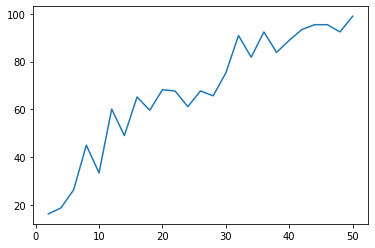

In [ ]:
### 실습 : 모든 checkpoint 에 대해 accuracy 를 계산하고 plot 해보세요
idxs = np.arange(2,51,2)  # 2~50 사이의 2 간격 숫자 생성
list_accuracy = []

for idx in idxs:
  checkpoint = torch.load(f'checkpoint-{idx}.pt')
  state_dict = checkpoint["model_state_dict"]
  vgg_loaded = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
  vgg_loaded.load_state_dict(state_dict)

  # 각 Epoch 마다의 accuracy를 출력해 봅니다.

  list_accuracy.append(eval_cktp(vgg_loaded, train_dataloader, verbose=False))
plt.plot(idxs, list_accuracy)

## 저장한 추가 정보 확인

In [ ]:
checkpoint = torch.load(f'checkpoint-36.pt')
print(checkpoint.keys())
print(checkpoint['description'])
print(checkpoint['optimizer_state_dict'].keys())

dict_keys(['model', 'epoch', 'model_state_dict', 'optimizer_state_dict', 'cost', 'description'])
VGG 체크포인트-36
dict_keys(['state', 'param_groups'])


## 저장된 모델 & Optimizer를 이용하여 학습

In [ ]:
#### Epoch 36에서의 정보를 모두 Load  한다음에 1번만 학습해 보겠습니다.

### 이전 모델 Load
model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
model.load_state_dict(checkpoint["model_state_dict"])

## 이전 Optimizer 의 정보 Load
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
checkpoint_epoch = checkpoint["epoch"]

## Epoch 1회만 학습
train_ckpt(model, train_dataloader, criterion, optimizer, n_epoch=1)

# 평가
eval_cktp(model, train_dataloader, verbose=True)

Test Accuracy: 92.42424242424242%


### 저장된 파일을 PC에 저장해 보겠습니다.

In [ ]:
from google.colab import files

# download checkpoint file
files.download('checkpoint-36.pt')
files.download('checkpoint-38.pt')
files.download('checkpoint-40.pt')
files.download('checkpoint-42.pt')
files.download('checkpoint-44.pt')
files.download('checkpoint-46.pt')
files.download('checkpoint-48.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# 각자 Download 폴더를 확인해 보세요
# 이 파일의 이름을 checkpoint-36-pc.pt 로 변경해보고 다시 server로 올려 보겠습니다.
files.upload()

{}

# 해당 파일을 이용하여 Precision, Recall, F1-Score를 분석하겠습니다

In [ ]:
### 실습 : 일정한 데이터가 오게 Dataloader 재선언
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

In [ ]:
# 실습 : Checkpoint  경로를 던지면 모델을 return 해 주는 함수를 작성해보세요
##      : CPU 에서 평가를 할 수 있도록 모델을 Load 해야 합니다
def load_model_from_checkpoint(ckpt_name):
  checkpoint = torch.load(ckpt_name, map_location=torch.device('cpu'))
  model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cpu")
  model.load_state_dict(checkpoint["model_state_dict"])
  return model

In [ ]:
## 실습 : CPU 에서 평가를 할 수 있도록 모델을 Load해 보세요.
model = load_model_from_checkpoint('checkpoint-36.pt')

In [ ]:
model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### 실습 : model에 대한 성능을 평가하는 모델을 만들어 보세요
### 실습 : CPU에서 동작하게 만들어야 합니다
def evaluate_performace(model, dataloader, verbose=False):

  model.eval()
  total = 0.0
  correct = 0.0

  precision, accuracy, recall, f1score = 0., 0., 0., 0.
  cnt = 0

  with torch.no_grad():
    for images, _,  labels in dataloader:
      ### CPU에서 진행하니 .cuda() 미사용!!
      images, labels = images.cpu(), labels.cpu()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      precision += precision_score(labels,predicted, average='macro')
      accuracy += accuracy_score(labels,predicted)
      recall += recall_score(labels,predicted, average='macro')
      f1score += f1_score(labels,predicted, average='macro')

      cnt += 1

  precision = 100 * precision / cnt
  accuracy = 100 * accuracy / cnt
  recall = 100 * recall / cnt
  f1score = f1score / cnt

  if verbose:
    print(f"precision:{precision:.2f}, accuracy:{accuracy:.2f}, recall:{recall:.2f}, f1_score:{f1score:.2f}")
  else:
    return precision, accuracy, recall, f1score



In [ ]:
evaluate_performace(model, train_dataloader, verbose=True)

precision:92.62, accuracy:91.41, recall:91.65, f1_score:0.92


## 과적합이 되었는지 여부 확인을 위해, 여러 check point 에 대해 작업수행

In [ ]:
for epoch in [30,36,40,46,50]:
  model = load_model_from_checkpoint(f'checkpoint-{epoch}.pt')
  print(f"Epoch [{epoch}] : ", end="")
  evaluate_performace(model, train_dataloader, verbose=True)

Epoch [30] : precision:84.29, accuracy:71.72, recall:71.74, f1_score:0.66
Epoch [36] : precision:90.39, accuracy:88.89, recall:89.21, f1_score:0.89
Epoch [40] : precision:93.60, accuracy:91.41, recall:91.59, f1_score:0.91
Epoch [46] : precision:96.47, accuracy:95.45, recall:95.48, f1_score:0.95
Epoch [50] : precision:98.76, accuracy:98.48, recall:98.48, f1_score:0.99


# 각 Class에 대한 예측정확도를 파악하고 싶습니다

In [ ]:
## 실습 : 전체 데이터를 한번에 가져오고, 이 결과를 기반으로 Report출력
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

labels, predicted,images, names = None, None, None, None
with torch.no_grad():
  for images, names,  labels in train_dataloader:
    ### CPU에서 진행하니 .cuda() 미사용!!
    images, labels = images.cpu(), labels.cpu()
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

from sklearn.metrics import classification_report
print(classification_report(labels, predicted))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        18
           8       1.00      0.83      0.91        18
           9       1.00      0.83      0.91        18
          10       1.00      1.00      1.00        18

    accuracy                           0.97       198
   macro avg       0.98      0.97      0.97       198
weighted avg       0.98      0.97      0.97       198



# Visualize 해보겠습니다

In [ ]:
labels.numpy() != predicted.numpy()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
idx_diff = np.where(labels.numpy() != predicted.numpy())
labels_diff = labels[idx_diff]
predicted_diff = predicted[idx_diff]
images_diff = images[idx_diff]

for t, p in zip(labels_diff, predicted_diff):
  print(f"정답 Label은 {t}, 예측 Label은 {p}")


정답 Label은 8, 예측 Label은 0
정답 Label은 8, 예측 Label은 0
정답 Label은 8, 예측 Label은 0
정답 Label은 9, 예측 Label은 0
정답 Label은 9, 예측 Label은 0
정답 Label은 9, 예측 Label은 0


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
[179 187 182 182 182]


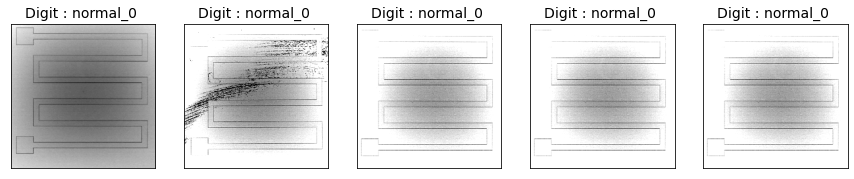

In [ ]:
### 실습 : label 이 0인 이미지 중 5개만 추려서 출력해 봅시다
target_index = np.where(labels.numpy() == 0)[0]
print(labels[target_index])
random_idx = np.random.choice(target_index, 5)
print(random_idx)
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_idx):

  plt.subplot(1, 5, i+1)
  plt.imshow(images[idx].squeeze(), cmap='gray_r')
  plt.title('Digit : {} '.format(names[idx]), fontsize=14)
  plt.xticks([]); plt.yticks([])


#  Deep Ensemble 수행

In [ ]:
list_models = []
for epoch in [30,36,40,46,50]:
  model = load_model_from_checkpoint(f'checkpoint-{epoch}.pt')
  list_models.append(model)

### 실습 : 일정한 데이터가 오게 Dataloader 재선언
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

In [ ]:
#### 실습 : Deep Ensemble 모델을 구성합니다.
#### 여러 모델을 읽어 온 후 그 결과를 Average 하여 정확도를 계산하니다.

images, labels = None, None
with torch.no_grad():

  ### 데이터를 읽어 들이고
  for images, names,  labels in train_dataloader:
    images, labels = images.cpu(), labels.cpu()


  ## 각 모델에 대해 순환
  outputs_stacked = None
  for i, model in enumerate(list_models[0:2]):

    outputs = model(images)

    if i == 0:
      outputs_stacked = outputs
    else:
      outputs_stacked = torch.stack([outputs_stacked,outputs], dim=2)

  #### Ensemble 결과 생성
  outputs_ensemble = outputs_stacked.mean(dim=2)
  _, predicted = torch.max(outputs_ensemble, 1)

  precision = precision_score(labels,predicted, average='macro')
  accuracy = accuracy_score(labels,predicted)
  recall = recall_score(labels,predicted, average='macro')
  f1score = f1_score(labels,predicted, average='macro')

  print(f"precision:{precision:.2f}, accuracy:{accuracy:.2f}, recall:{recall:.2f}, f1_score:{f1score:.2f}")


precision:0.95, accuracy:0.93, recall:0.94, f1_score:0.93
